In [1]:
import torch

torch.__version__

'0.4.1'

In [2]:
%matplotlib inline

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import pandas as pd
import numpy as np

def findFiles(path): return glob.glob(path)

print(findFiles('data/labels/*.txt'))

all_letters = "arndbceqzghilkmfpstwyv"
n_letters = len(all_letters)


# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return lines

for filename in findFiles('data/labels/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/labels/negative.txt', 'data/labels/positive.txt']


In [4]:
# make sure negative index is 0
all_categories.sort()
all_categories

['negative', 'positive']

In [5]:
n_letters

22

In [6]:
print(category_lines['positive'][:5])

['AAIANYHYDADENSK', 'AGTWSALNSIQQFIS', 'AKGMMHMIKKGANGS', 'ALREKVLGLPAIKAW', 'ATDYENYAIVEGCPA']


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    line = line.lower()
    tensor = torch.tensor([letterToIndex(letter) for letter in line], dtype=torch.long).to(device) 
    tensor = tensor.view(-1, 1)
    return tensor

print(lineToTensor('AAIANYHYDADENSK'))
print(lineToTensor('AAIANYHYDADENSK').size())

tensor([[ 0],
        [ 0],
        [11],
        [ 0],
        [ 2],
        [20],
        [10],
        [20],
        [ 3],
        [ 0],
        [ 3],
        [ 6],
        [ 2],
        [17],
        [13]])
torch.Size([15, 1])


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.e = nn.Embedding(input_size, input_size//2)
        self.lstm = nn.LSTM(input_size//2, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedding = self.e(input)
        embedding = embedding.view(1, 1, -1)
        lstm_out, hidden = self.lstm(
            embedding, hidden)
        output = self.softmax(self.i2o(lstm_out.view(1, -1)))
        return output, hidden

    def initHidden(self):
        return (torch.rand(1, 1, self.hidden_size).to(device) ,
                torch.rand(1, 1, self.hidden_size).to(device))

n_hidden = 128
model = MyLSTM(n_letters, n_hidden, n_categories).to(device)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [9]:
input = lineToTensor('AAIANYHYDADENSK')
hidden = model.initHidden()

output, next_hidden = model(input[0], hidden)
print(input[0])
print(output)
print(output.shape)

tensor([0])
tensor([[-0.6056, -0.7891]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 2])


Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('negative', 0)


In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = positive / line = AGTWSALNSIQQFIS
category = negative / line = TAPPILQGNAGLSVK
category = negative / line = FSVGWLYWYFWVIVV
category = negative / line = SKKKCDELAAKLSGL
category = positive / line = GSDPKKLVLNIKYTR
category = positive / line = EKISVAKIFAHEKYD
category = negative / line = QQRVWKALLTIPYGE
category = negative / line = SKLDAAYKLAYKTAE
category = positive / line = TVFETALKKAITAMS
category = negative / line = HPARLVEDINRVFLC


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [12]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)

In [13]:
def train(category_tensor, line_tensor):
    hidden = model.initHidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [14]:
import time
import math

n_iters = 30000
print_every = 2000
plot_every = 2000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

2000 6% (0m 46s) 0.6276 QFKPEEITGIMKDFD / negative ✓
4000 13% (1m 35s) 0.6867 VGKTVWFVPSIKAGN / positive ✓
6000 20% (2m 23s) 0.8990 EGKVVGLYGNGVVTK / negative ✗ (positive)
8000 26% (3m 10s) 1.1800 SDIKERFAQLCEEHG / negative ✗ (positive)
10000 33% (3m 57s) 0.3937 QIPSLASLANLHLPQ / negative ✓
12000 40% (4m 45s) 0.9996 GNQNFLTVFDSTSCN / positive ✗ (negative)
14000 46% (5m 32s) 1.1848 SGQHRLWVRNSGSEPA / negative ✗ (positive)
16000 53% (6m 19s) 0.6860 GGFKKTDKHPPKDWG / positive ✓
18000 60% (7m 7s) 1.2465 IHQIFNIVRDTRGLP / positive ✗ (negative)
20000 66% (7m 56s) 0.9177 PANDKFTVFEAAFND / negative ✗ (positive)
22000 73% (8m 42s) 1.2133 CEEHGILRENIIDLS / negative ✗ (positive)
24000 80% (9m 29s) 1.2269 WSERAGEAMVLVYYES / negative ✗ (positive)
26000 86% (10m 15s) 0.8518 AQDIWGTSAAAYFVG / positive ✗ (negative)
28000 93% (11m 2s) 0.8408 CGGSLISSRTVLTAA / negative ✗ (positive)
30000 100% (11m 47s) 0.6467 YFALEAYAFDIAAPG / positive ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




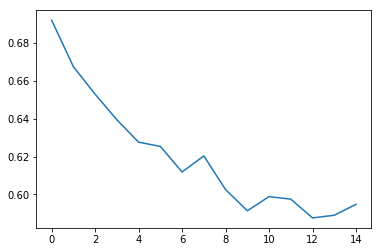

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [16]:
all_losses[-5:]

[0.5988904912173748,
 0.5975370786488056,
 0.5876611967533827,
 0.5890739852190018,
 0.5948267067670823]

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




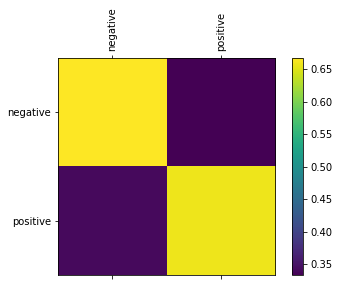

In [17]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = model.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    with torch.no_grad():
        output = evaluate(line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [18]:
#torch.save(model, "models/lstm_15000.pth")

In [19]:
import pandas as pd
import numpy as np

valid = pd.read_csv("data/valid.csv")
valid["Immunogenicity"] = valid["Immunogenicity"].map(lambda n: 0 if n == -1 else n)
valid.head()

,PubMed ID,Peptide,Immunogenicity
0,1706620,QGHNMPNDPNRNVDENANAN,1
1,1706620,VTCGNGIQVRIKPGSANKPK,1
2,11241296,AAFVGAAATLVSLLTFMIAATYNFAVLKLMGR,1
3,11241296,ENPVVHFFKNIVTPRTP,1
4,11241296,GTASFFFLYGALLLAYGFYTTGAVRQIFGDYK,1


In [20]:
len(valid["PubMed ID"].unique())

57

In [21]:
# group by PubMedi ID
grouped = valid.groupby("PubMed ID")

In [22]:
auc_scores = []

In [23]:
def predict(peptide):
    with torch.no_grad():
        output = evaluate(lineToTensor(peptide))
        log_prob = output[0][1].item()
        prob = np.exp(log_prob)
        
        top_v, top_i = output.topk(1)
        category_i = top_i[0].item()
        return (prob, category_i)

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

for _, group in grouped:
    valid_peptides = group["Peptide"].tolist()
    valid_targets = group["Immunogenicity"].tolist()
    
    probs = []
    predictions = []

    for peptide in valid_peptides:
        prob, pred = predict(peptide)
        probs.append(prob)
        predictions.append(pred)
        
    auc_score = roc_auc_score(valid_targets, probs)
    auc_scores.append(auc_score)

In [25]:
print(len(auc_scores))

57


In [26]:
auc_scores = np.asarray(auc_scores)
auc_scores.mean()

0.6245193356286296

In [27]:
auc_scores

array([0.79166667, 0.25      , 0.63333333, 0.57142857, 0.67142857,
       0.85714286, 0.61111111, 0.55555556, 0.74285714, 0.60034014,
       0.55882353, 0.6       , 0.60714286, 0.61111111, 0.9       ,
       0.755     , 0.52777778, 0.95238095, 0.57432432, 0.6489899 ,
       1.        , 0.66666667, 0.48571429, 0.60555556, 0.38461538,
       0.53125   , 0.63859649, 0.71428571, 0.55494505, 1.        ,
       0.68852459, 0.10416667, 0.8       , 0.65833333, 0.5269131 ,
       0.56902357, 0.61458333, 0.53325123, 0.82638889, 0.49579832,
       0.53546454, 0.66458333, 0.49444444, 0.46212121, 0.57407407,
       0.49942396, 0.93333333, 0.88333333, 0.25      , 0.68181818,
       0.54358974, 0.60702341, 0.72222222, 0.78064516, 0.5       ,
       0.42745098, 0.61904762])